In [2]:
using JuMP, Gurobi, Random, PyPlot, Dates, LinearAlgebra

In [3]:
GUROBI_ENV = Gurobi.Env()

Academic license - for non-commercial use only


Gurobi.Env(Ptr{Nothing} @0x00007fbfee22a200)

# MIO Implementation

In [4]:
function get_group_indicator_matrix(
    group_assignments::Array{Int64, 1}
)::Array{Int64, 2}
    n = size(group_assignments, 1)
    p = size(unique(group_assignments), 1)
    A = zeros(n, p)
    for i=1:n
        for k=1:p
            A[i,k] = Int(group_assignments[i] .== k)
        end
    end
    return A
end

get_group_indicator_matrix (generic function with 1 method)

In [5]:
function lasso_regressor(
    X::Array{Float64, 2}, 
    y::Array{Float64, 1};
    Γ::Float64=0.01,
    return_objective_value::Bool = false,
    solver_time_limit::Int64=60  
)::Union{Array{Float64, 1}, Float64}
    
    # Initialize model
    model = Model(solver=GurobiSolver(OutputFlag=0, TimeLimit=solver_time_limit, GUROBI_ENV))
    
    # Define variables
    n, d = size(X)
    @variable(model, β[1:d])
    @variable(model, β_abs[1:d])
    @variable(model, t)

    # Set constraints
    @constraint(model, β_abs .>= β)
    @constraint(model, β_abs .>= -β)
    @constraint(model, t .== (y - X*β)'*(y - X*β)/n + Γ*ones(d)'*β_abs)
    
    # Set objective         
    @objective(model, Min, t);
    
    # Solve and return optimal objective value or regression coefficients
    solve(model)
    if return_objective_value
        return getobjectivevalue(model)
    else
        return getvalue(β) 
    end
end

lasso_regressor (generic function with 1 method)

In [17]:
function fair_lasso_regressor(
    X::Array{Float64, 2}, 
    y::Array{Float64, 1},
    group_assignments::Array{Int64, 1};
    Γ::Float64=0.01, # regularization penalty
    δ::Float64=0.1, # max percent optimality decrease
    λ::Float64=1.0, # mean overshoot weight,
    μ::Float64=1.0, # meane value weight
    return_objective_value::Bool = false,
    solver_time_limit::Int64=60,
    log::Bool = false
)::Array{Float64, 1}
    
    start_time = now()
    
    # Process inputs
    A = get_group_indicator_matrix(group_assignments) 
    p = size(A, 2) # number of groups
    q = Int(p*(p - 1)/2) # number of pairs of groups
    n, d = size(X) # number of data points and number of features
    group_size = [sum(A[k,:]) for k=1:p]
    min_loss = lasso_regressor(X, y; Γ=Γ, return_objective_value=true) # Min loss of problem w/o fairness constraints
    
    # Initialize model
    model = Model(solver=GurobiSolver(OutputFlag=0, TimeLimit=solver_time_limit, GUROBI_ENV))

    # Define variables
    @variable(model, β[1:d])
    @variable(model, β_abs[1:d])
    @variable(model, undershoot[1:n] >= 0)
    @variable(model, overshoot[1:n] >= 0)
    @variable(model, MU[1:p] >= 0)
    @variable(model, MO[1:p] >= 0)
    @variable(model, MV[1:p])
    @variable(model, Δ_MO[1:q] >= 0)
    @variable(model, Δ_MU[1:q] >= 0)
    @variable(model, Δ_MV[1:q] >= 0)
    @variable(model, t >= 0)
                                
    # Set LASSO regression performance constraints
    @constraint(model, β_abs .>= β)
    @constraint(model, β_abs .>= -β)
    @constraint(model, (y - X*β)'*(y - X*β)/n + Γ*ones(d)'*β_abs .<= (1 + δ)*min_loss)
    
    # Set constraints for overshoot and undershoot variables 
    @constraint(model, overshoot .>= X*β - y)
    @constraint(model, undershoot .>= y - X*β)
    
    # Set constraints for mean overshoot, mean undershoot and mean value calculation   
    @constraint(model, MU .== (A'*undershoot)./group_size)
    @constraint(model, MO .== (A'*overshoot)./group_size)
    @constraint(model, MV .== (A'*X*β)./group_size)
    
    # Set fairness constraints
    @constraint(model, [k=1:p, l=k+1:p, m=Int(l-k+(p-k/2)*(k-1))], Δ_MU[m] >= MU[k] - MU[l])
    @constraint(model, [k=1:p, l=k+1:p, m=Int(l-k+(p-k/2)*(k-1))], Δ_MU[m] >= MU[l] - MU[k])
    @constraint(model, [k=1:p, l=k+1:p, m=Int(l-k+(p-k/2)*(k-1))], Δ_MO[m] >= MO[k] - MO[l])
    @constraint(model, [k=1:p, l=k+1:p, m=Int(l-k+(p-k/2)*(k-1))], Δ_MO[m] >= MO[l] - MO[k])
    @constraint(model, [k=1:p, l=k+1:p, m=Int(l-k+(p-k/2)*(k-1))], Δ_MV[m] >= MV[k] - MV[l])
    @constraint(model, [k=1:p, l=k+1:p, m=Int(l-k+(p-k/2)*(k-1))], Δ_MV[m] >= MV[l] - MV[k])
    @constraint(model, t .== ones(q)'*(Δ_MU .+ λ*Δ_MO .+ μ*Δ_MV))
    
    # Set objective
    @objective(model, Min, t)
    
    # Solve model
    solve(model)
         
    # Return optimal objective value or regression coefficients
    if return_objective_value
        return getobjectivevalue(model)
    else
        return getvalue(β) 
    end
end

fair_lasso_regressor (generic function with 1 method)

# Fairness score calculation

In [30]:
function calculate_mean_overshoot(
    y::Array{Float64, 1},
    y_hat::Array{Float64, 1}
)::Float64
    return sum(max.(y_hat .- y, 0)) / size(y, 1)
end


function calculate_mean_undershoot(
    y::Array{Float64, 1},
    y_hat::Array{Float64, 1}
)::Float64
    return sum(max.(y .- y_hat, 0)) / size(y, 1)
end


function calculate_mean_value(
    y::Array{Float64, 1},
    y_hat::Array{Float64, 1}
)::Float64
    return sum(y_hat) / size(y, 1)
end


function calculate_fairness_score_for_metric(
    y::Array{Float64, 1},
    y_hat::Array{Float64, 1},
    group_assignments::Array{Int64, 1},
    metric::Function
)::Float64
    group_metrics = [metric(y[group_assignments .== k], y_hat[group_assignments .== k]) for k=1:p]
    return sum([sum([abs(group_metrics[k] - group_metrics[l]) for l=k+1:p]) for k=1:p]) / (p*(p - 1)/2)
end


function calculate_fairness_scores(
    y::Array{Float64, 1}, 
    y_hat::Array{Float64, 1},
    group_assignments::Array{Int64, 1}
)::Tuple{Float64, Float64, Float64}
    Δ_MU = calculate_fairness_score_for_metric(y, y_hat, group_assignments, calculate_mean_undershoot)
    Δ_MO = calculate_fairness_score_for_metric(y, y_hat, group_assignments, calculate_mean_overshoot)
    Δ_MV = calculate_fairness_score_for_metric(y, y_hat, group_assignments, calculate_mean_value)
    return Δ_MU, Δ_MO, Δ_MV
end


function regressor_fairness_summary(
    X::Array{Float64, 2},
    y::Array{Float64, 1},
    group_assignments::Array{Int64, 1},
    β::Array{Float64, 1}, 
)
    y_hat = X*β
    Δ_MU, Δ_MO, Δ_MV = calculate_fairness_scores(y, y_hat, group_assignments)
    println("Mean undershoot discrepency: ", round(Δ_MU; digits=3))
    println("Mean overshoot discrepency: ", round(Δ_MO; digits=3))
    println("Mean value discrepency: ", round(Δ_MV; digits=3))
end

regressor_fairness_summary (generic function with 1 method)

# Random data generation

In [7]:
function generate_random_regression_data(
    n::Int64, 
    d::Int64, 
    p::Int64; 
    σ=0.1, 
    seed=42
)::Tuple{Array{
    Float64, 2}, Array{Float64, 1}, Array{Int64, 1}}
    rng = MersenneTwister(seed)
    group_assignments = rand(rng, 1:p, n)
    X = rand(rng, n, d) .* [group_assignments[i] for i=1:n,j=1:d]
    β_true = randn(rng, d) .* rand(rng, [0, 1], d)
    y = X*β_true + σ*randn(rng, n)
    return X, y, group_assignments
end

generate_random_regression_data (generic function with 1 method)

# Toy example

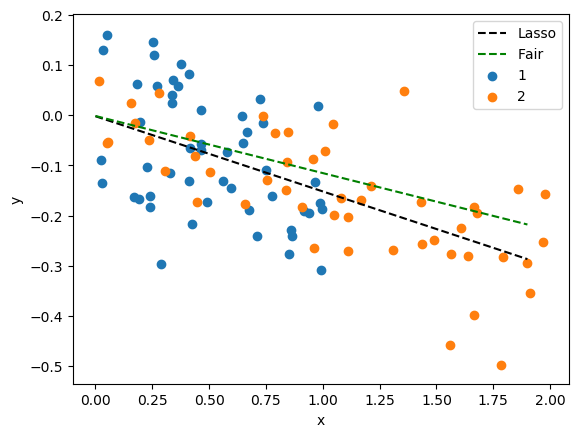

In [26]:
# Example of random data 
n = 100
d = 1
p = 2
X, y, group_assignments = generate_random_regression_data(100, 1, 2)
β = lasso_regressor(X, y)
β_fair = fair_lasso_regressor(X, y, group_assignments)
for k=1:p
    plt.scatter(x[group_assignments .== k], y[group_assignments .== k], label=k)
end
X_grid = minimum(X):0.1:maximum(X)
plt.plot(x_grid, β_lasso.*X_grid, color="k", linestyle="--", label="Lasso")
plt.plot(x_grid, β_fair.*X_grid, color="g", linestyle="--", label="Fair")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

In [31]:
regressor_fairness_summary(x, y, group_assignments, β)

Mean undershoot discrepency: 0.012
Mean overshoot discrepency: 0.015
Mean value discrepency: 0.083


In [32]:
regressor_fairness_summary(x, y, group_assignments, β_fair)

Mean undershoot discrepency: 0.019
Mean overshoot discrepency: 0.003
Mean value discrepency: 0.063
